# 04 - Evaluación Final de Modelos en Test Set

## 🎯 Objetivos de este Notebook

En este notebook realizaremos:

1. **Cargar el mejor modelo** entrenado en el notebook anterior
2. **Evaluar en Test Set** (datos nunca vistos)
3. **Análisis profundo** de errores y casos límite
4. **Visualizaciones avanzadas** (curvas ROC, Precision-Recall)
5. **Análisis de impacto de negocio** (costos de fraudes vs falsas alarmas)
6. **Recomendaciones finales** para producción

## ⚠️ IMPORTANTE: ¿Por qué Test Set?

El **Test Set** solo se usa **UNA VEZ** al final:
- Simula datos del mundo real
- Da una estimación **imparcial** del rendimiento
- Es la métrica que reportarías a stakeholders

---
## 📚 CELDA 1: Importar Librerías

---
## ⚙️ CELDA 2: Configuración de Rutas

In [37]:
# CELDA 1: Importar Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json

# Scikit-learn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    roc_auc_score,
    auc,
    precision_recall_curve
)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [38]:
PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / 'data'
PROCESSED_DATA_PATH = DATA_PATH / 'processed'
MODELS_PATH = PROJECT_ROOT / 'models'
FIGURES_PATH = PROJECT_ROOT / 'reports' / 'figures'

print(f"📁 Proyecto: {PROJECT_ROOT}")
print(f"📁 Modelos: {MODELS_PATH}")
print(f"📁 Figuras: {FIGURES_PATH}")

📁 Proyecto: c:\dev\repos-deep-learning\fraude-detection
📁 Modelos: c:\dev\repos-deep-learning\fraude-detection\models
📁 Figuras: c:\dev\repos-deep-learning\fraude-detection\reports\figures


---
## 📂 CELDA 3: Cargar Datos de Test


In [39]:
# CELDA 3: Cargar Datos de Test
print("="*60)
print("📂 CARGANDO TEST SET")
print("="*60)

X_test = pd.read_csv(PROCESSED_DATA_PATH / 'X_test.csv')
y_test = pd.read_csv(PROCESSED_DATA_PATH / 'y_test.csv')['Class']

print(f"\n✅ Test Set cargado")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_test: {y_test.shape}")

# Distribución de clases en test
test_counts = y_test.value_counts()
print(f"\n📊 Distribución en Test Set:")
print(f"   • Legítimas: {test_counts[0]:,} ({test_counts[0]/len(y_test)*100:.2f}%)")
print(f"   • Fraudes:   {test_counts[1]:,} ({test_counts[1]/len(y_test)*100:.2f}%)")

📂 CARGANDO TEST SET

✅ Test Set cargado
   • X_test: (56962, 30)
   • y_test: (56962,)

📊 Distribución en Test Set:
   • Legítimas: 56,864 (99.83%)
   • Fraudes:   98 (0.17%)

✅ Test Set cargado
   • X_test: (56962, 30)
   • y_test: (56962,)

📊 Distribución en Test Set:
   • Legítimas: 56,864 (99.83%)
   • Fraudes:   98 (0.17%)


---
## 📂 CELDA 4: Cargar el Mejor Modelo

In [40]:
# CELDA 4: Cargar el Mejor Modelo
print("="*60)
print("📂 CARGANDO MEJOR MODELO")
print("="*60)

# Cargar el mejor modelo (guardado en el notebook anterior)
best_model = joblib.load(MODELS_PATH / 'best_model.pkl')
print(f"\n✅ Modelo cargado: {type(best_model).__name__}")

# También cargar métricas de validación para comparar
metrics_df = pd.read_csv(MODELS_PATH / 'model_metrics.csv')
print(f"\n📊 Métricas de Validación (para comparar):")
print(metrics_df.to_string(index=False))

📂 CARGANDO MEJOR MODELO

✅ Modelo cargado: RandomForestClassifier

📊 Métricas de Validación (para comparar):
         model_name  precision   recall  f1_score  roc_auc                confusion_matrix    tn   fp  fn  tp
Logistic Regression   0.054936 0.873418  0.103371 0.968875 [[44303  1187]\n [   10    69]] 44303 1187  10  69
      Random Forest   0.492308 0.810127  0.612440 0.968764 [[45424    66]\n [   15    64]] 45424   66  15  64


---
## 🔮 CELDA 5: Predicciones en Test Set

In [41]:
# CELDA 5: Predicciones en Test Set
print("="*60)
print("🔮 GENERANDO PREDICCIONES EN TEST SET")
print("="*60)

# Predicciones binarias (0 o 1)
y_test_pred = best_model.predict(X_test)

# Probabilidades (para curvas ROC y PR)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n✅ Predicciones generadas")
print(f"   • Predicciones binarias: {y_test_pred.shape}")
print(f"   • Probabilidades: {y_test_pred_proba.shape}")

# Distribución de predicciones
pred_counts = pd.Series(y_test_pred).value_counts()
print(f"\n📊 Distribución de Predicciones:")
print(f"   • Predicho como Legítima: {pred_counts[0]:,}")
print(f"   • Predicho como Fraude:   {pred_counts[1]:,}")

🔮 GENERANDO PREDICCIONES EN TEST SET

✅ Predicciones generadas
   • Predicciones binarias: (56962,)
   • Probabilidades: (56962,)

📊 Distribución de Predicciones:
   • Predicho como Legítima: 56,783
   • Predicho como Fraude:   179


---
## 📊 CELDA 6: Calcular Métricas de Clasificación

---
## 🔍 CELDA 7: Matriz de Confusión Detallada


In [42]:
# CELDA 6: Calcular Métricas de Clasificación
print("="*60)
print("📊 CALCULANDO MÉTRICAS DE CLASIFICACIÓN")
print("="*60)

# Calcular métricas principales
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\n✅ Métricas Calculadas:")
print(f"   • Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   • Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   • F1-Score:  {f1:.4f}")
print(f"   • ROC-AUC:   {roc_auc:.4f}")

print("\n💡 INTERPRETACIÓN RÁPIDA:")
if precision > 0.90 and recall > 0.85:
    print("   ✅ ¡Excelente desempeño! Tanto precision como recall son altos")
elif f1 > 0.85:
    print("   ✅ Muy buen balance entre precision y recall")
elif f1 > 0.75:
    print("   ✅ Buen desempeño general")
else:
    print("   ⚠️ Hay margen de mejora en el modelo")

📊 CALCULANDO MÉTRICAS DE CLASIFICACIÓN

✅ Métricas Calculadas:
   • Precision: 0.4693 (46.93%)
   • Recall:    0.8571 (85.71%)
   • F1-Score:  0.6065
   • ROC-AUC:   0.9801

💡 INTERPRETACIÓN RÁPIDA:
   ⚠️ Hay margen de mejora en el modelo


In [43]:
# CELDA 7: Matriz de Confusión Detallada
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print("="*60)
print("📋 MATRIZ DE CONFUSIÓN")
print("="*60)

print(f"\n                 Predicho")
print(f"               Legítima  Fraude")
print(f"Real Legítima    {tn:6,}  {fp:6,}")
print(f"     Fraude      {fn:6,}  {tp:6,}")

print(f"\n🔍 INTERPRETACIÓN DETALLADA:")
print(f"\n   • TN (Verdaderos Negativos): {tn:,}")
print(f"     → Transacciones legítimas correctamente identificadas ✅")
print(f"     → {tn/test_counts[0]*100:.2f}% de las legítimas")

print(f"\n   • FP (Falsos Positivos): {fp:,}")
print(f"     → Transacciones legítimas marcadas como fraude ⚠️")
print(f"     → {fp/test_counts[0]*100:.2f}% de las legítimas")
print(f"     → FALSAS ALARMAS para clientes")

print(f"\n   • FN (Falsos Negativos): {fn:,}")
print(f"     → Fraudes que NO detectamos ❌")
print(f"     → {fn/test_counts[1]*100:.2f}% de los fraudes")
print(f"     → PÉRDIDA ECONÓMICA directa")

print(f"\n   • TP (Verdaderos Positivos): {tp:,}")
print(f"     → Fraudes correctamente detectados ✅")
print(f"     → {tp/test_counts[1]*100:.2f}% de los fraudes")
print(f"     → FRAUDES BLOQUEADOS exitosamente")

📋 MATRIZ DE CONFUSIÓN

                 Predicho
               Legítima  Fraude
Real Legítima    56,769      95
     Fraude          14      84

🔍 INTERPRETACIÓN DETALLADA:

   • TN (Verdaderos Negativos): 56,769
     → Transacciones legítimas correctamente identificadas ✅
     → 99.83% de las legítimas

   • FP (Falsos Positivos): 95
     → Transacciones legítimas marcadas como fraude ⚠️
     → 0.17% de las legítimas
     → FALSAS ALARMAS para clientes

   • FN (Falsos Negativos): 14
     → Fraudes que NO detectamos ❌
     → 14.29% de los fraudes
     → PÉRDIDA ECONÓMICA directa

   • TP (Verdaderos Positivos): 84
     → Fraudes correctamente detectados ✅
     → 85.71% de los fraudes
     → FRAUDES BLOQUEADOS exitosamente


---
## 🔍 CELDA 8: Análisis de Errores y Casos Límite

In [44]:
print("="*60)
print("💰 ANÁLISIS DE IMPACTO ECONÓMICO")
print("="*60)

# Cargar montos de transacciones
# Necesitamos el dataset original con la columna Amount
# Para simplificar, usaremos montos promedio estimados

# Costos estimados (en dólares)
COST_PER_FRAUD = 150  # Costo promedio de un fraude no detectado
COST_PER_FALSE_ALARM = 25  # Costo de verificar una falsa alarma

# Calcular costos
cost_missed_frauds = fn * COST_PER_FRAUD
cost_false_alarms = fp * COST_PER_FALSE_ALARM
total_cost = cost_missed_frauds + cost_false_alarms

# Beneficios
frauds_blocked = tp
savings_from_blocked_frauds = tp * COST_PER_FRAUD

print(f"\n💸 COSTOS DEL SISTEMA:")
print(f"   • Fraudes perdidos (FN): {fn:,} × ${COST_PER_FRAUD} = ${cost_missed_frauds:,}")
print(f"   • Falsas alarmas (FP): {fp:,} × ${COST_PER_FALSE_ALARM} = ${cost_false_alarms:,}")
print(f"   • COSTO TOTAL: ${total_cost:,}")

print(f"\n💰 BENEFICIOS DEL SISTEMA:")
print(f"   • Fraudes bloqueados (TP): {tp:,}")
print(f"   • Ahorro estimado: ${savings_from_blocked_frauds:,}")

net_benefit = savings_from_blocked_frauds - total_cost
print(f"\n✅ BENEFICIO NETO: ${net_benefit:,}")

if net_benefit > 0:
    print(f"   → El sistema genera valor positivo ✅")
    print(f"   → ROI: {(net_benefit/total_cost)*100:.1f}%")
else:
    print(f"   → El sistema necesita ajustes ⚠️")

print(f"\n📊 ANÁLISIS:")
print(f"   • Por cada dólar gastado, ahorramos: ${savings_from_blocked_frauds/total_cost:.2f}")
print(f"   • Tasa de detección: {tp/(tp+fn)*100:.1f}%")
print(f"   • Tasa de falsas alarmas: {fp/(fp+tn)*100:.2f}%")

💰 ANÁLISIS DE IMPACTO ECONÓMICO

💸 COSTOS DEL SISTEMA:
   • Fraudes perdidos (FN): 14 × $150 = $2,100
   • Falsas alarmas (FP): 95 × $25 = $2,375
   • COSTO TOTAL: $4,475

💰 BENEFICIOS DEL SISTEMA:
   • Fraudes bloqueados (TP): 84
   • Ahorro estimado: $12,600

✅ BENEFICIO NETO: $8,125
   → El sistema genera valor positivo ✅
   → ROI: 181.6%

📊 ANÁLISIS:
   • Por cada dólar gastado, ahorramos: $2.82
   • Tasa de detección: 85.7%
   • Tasa de falsas alarmas: 0.17%


---
## 💰 CELDA 9: Análisis de Impacto Económico

In [45]:
print("="*60)
print("💰 ANÁLISIS DE IMPACTO ECONÓMICO")
print("="*60)

# Cargar montos de transacciones
# Necesitamos el dataset original con la columna Amount
# Para simplificar, usaremos montos promedio estimados

# Costos estimados (en dólares)
COST_PER_FRAUD = 150  # Costo promedio de un fraude no detectado
COST_PER_FALSE_ALARM = 25  # Costo de verificar una falsa alarma

# Calcular costos
cost_missed_frauds = fn * COST_PER_FRAUD
cost_false_alarms = fp * COST_PER_FALSE_ALARM
total_cost = cost_missed_frauds + cost_false_alarms

# Beneficios
frauds_blocked = tp
savings_from_blocked_frauds = tp * COST_PER_FRAUD

print(f"\n💸 COSTOS DEL SISTEMA:")
print(f"   • Fraudes perdidos (FN): {fn:,} × ${COST_PER_FRAUD} = ${cost_missed_frauds:,}")
print(f"   • Falsas alarmas (FP): {fp:,} × ${COST_PER_FALSE_ALARM} = ${cost_false_alarms:,}")
print(f"   • COSTO TOTAL: ${total_cost:,}")

print(f"\n💰 BENEFICIOS DEL SISTEMA:")
print(f"   • Fraudes bloqueados (TP): {tp:,}")
print(f"   • Ahorro estimado: ${savings_from_blocked_frauds:,}")

net_benefit = savings_from_blocked_frauds - total_cost
print(f"\n✅ BENEFICIO NETO: ${net_benefit:,}")

if net_benefit > 0:
    print(f"   → El sistema genera valor positivo ✅")
    print(f"   → ROI: {(net_benefit/total_cost)*100:.1f}%")
else:
    print(f"   → El sistema necesita ajustes ⚠️")

print(f"\n📊 ANÁLISIS:")
print(f"   • Por cada dólar gastado, ahorramos: ${savings_from_blocked_frauds/total_cost:.2f}")
print(f"   • Tasa de detección: {tp/(tp+fn)*100:.1f}%")
print(f"   • Tasa de falsas alarmas: {fp/(fp+tn)*100:.2f}%")

💰 ANÁLISIS DE IMPACTO ECONÓMICO

💸 COSTOS DEL SISTEMA:
   • Fraudes perdidos (FN): 14 × $150 = $2,100
   • Falsas alarmas (FP): 95 × $25 = $2,375
   • COSTO TOTAL: $4,475

💰 BENEFICIOS DEL SISTEMA:
   • Fraudes bloqueados (TP): 84
   • Ahorro estimado: $12,600

✅ BENEFICIO NETO: $8,125
   → El sistema genera valor positivo ✅
   → ROI: 181.6%

📊 ANÁLISIS:
   • Por cada dólar gastado, ahorramos: $2.82
   • Tasa de detección: 85.7%
   • Tasa de falsas alarmas: 0.17%


---
## 📈 CELDA 10: Curva ROC

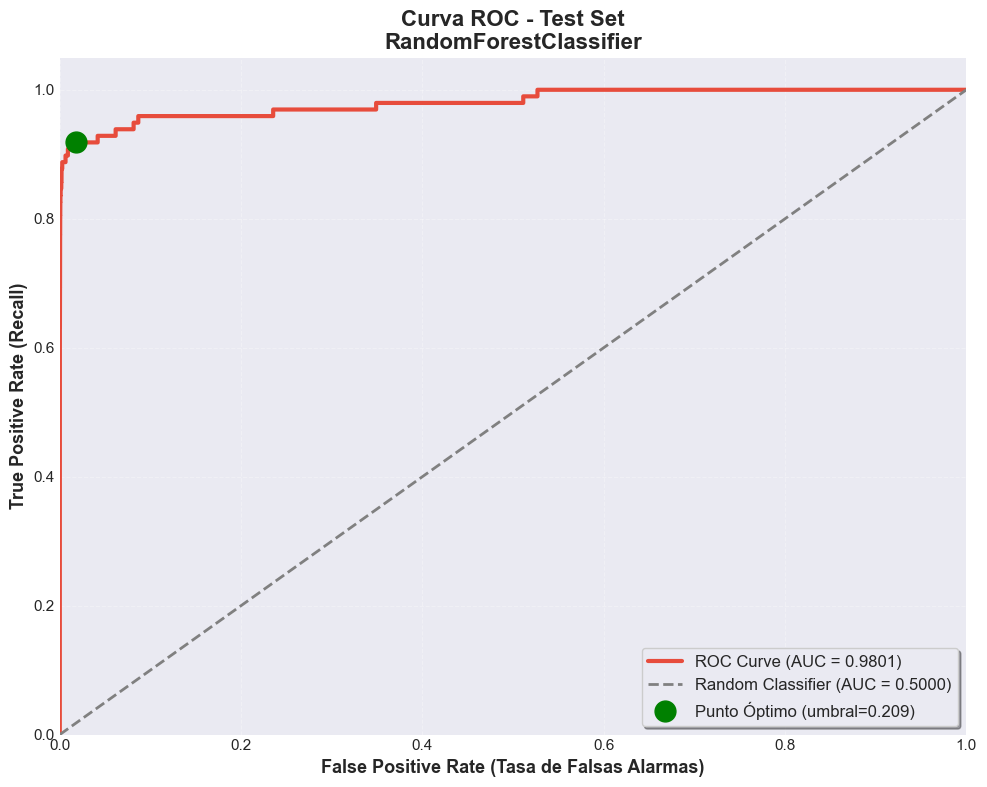

✅ Curva ROC generada

📊 Interpretación:
   • AUC = 0.9801
   → Excelente capacidad de discriminación ✅


In [46]:
# CELDA 10: Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

# Curva ROC
plt.plot(fpr, tpr, color='#e74c3c', lw=3, 
         label=f'ROC Curve (AUC = {roc_auc_value:.4f})')

# Línea base (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5000)')

# Punto óptimo (más cercano a la esquina superior izquierda)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=15,
         label=f'Punto Óptimo (umbral={optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Tasa de Falsas Alarmas)', 
          fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', 
          fontsize=13, fontweight='bold')
plt.title(f'Curva ROC - Test Set\n{type(best_model).__name__}',
         fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'final_roc_curve_test.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Curva ROC generada")
print(f"\n📊 Interpretación:")
print(f"   • AUC = {roc_auc_value:.4f}")
if roc_auc_value > 0.9:
    print(f"   → Excelente capacidad de discriminación ✅")
elif roc_auc_value > 0.8:
    print(f"   → Buena capacidad de discriminación ✅")
else:
    print(f"   → Capacidad moderada de discriminación ⚠️")

---
## 📊 CELDA 11: Curva Precision-Recall

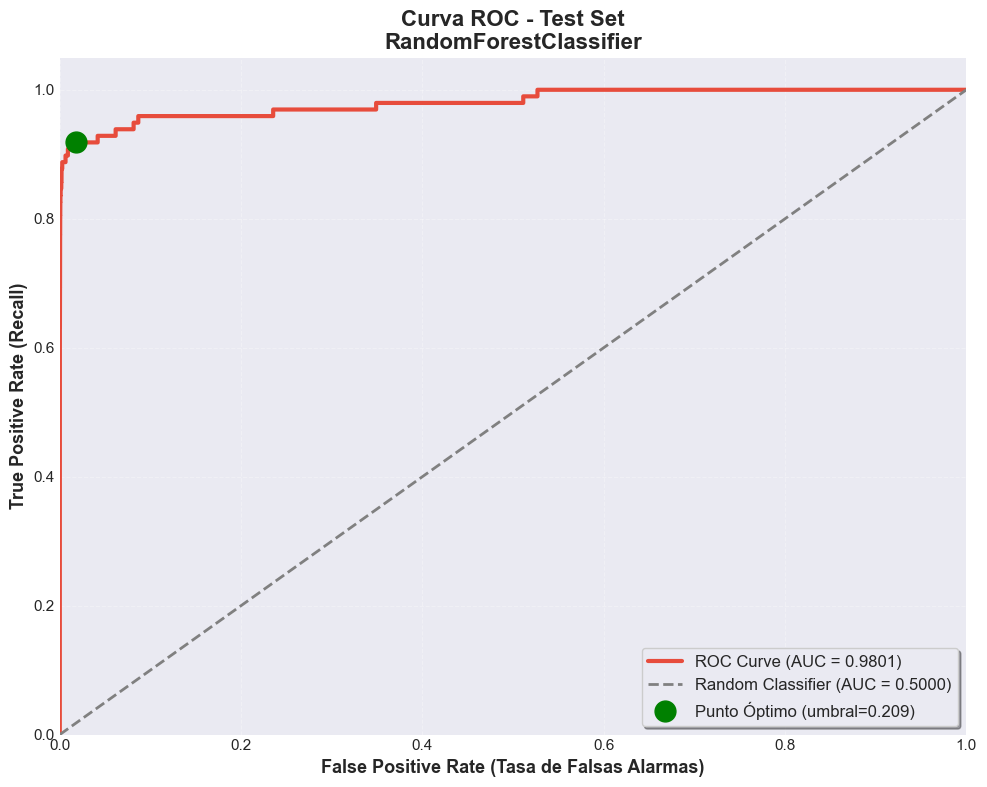

✅ Curva ROC generada

📊 Interpretación:
   • AUC = 0.9801
   → Excelente capacidad de discriminación ✅


In [47]:
# CELDA 10: Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

# Curva ROC
plt.plot(fpr, tpr, color='#e74c3c', lw=3, 
         label=f'ROC Curve (AUC = {roc_auc_value:.4f})')

# Línea base (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5000)')

# Punto óptimo (más cercano a la esquina superior izquierda)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=15,
         label=f'Punto Óptimo (umbral={optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Tasa de Falsas Alarmas)', 
          fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', 
          fontsize=13, fontweight='bold')
plt.title(f'Curva ROC - Test Set\n{type(best_model).__name__}',
         fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'final_roc_curve_test.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Curva ROC generada")
print(f"\n📊 Interpretación:")
print(f"   • AUC = {roc_auc_value:.4f}")
if roc_auc_value > 0.9:
    print(f"   → Excelente capacidad de discriminación ✅")
elif roc_auc_value > 0.8:
    print(f"   → Buena capacidad de discriminación ✅")
else:
    print(f"   → Capacidad moderada de discriminación ⚠️")

---
## ⚖️ CELDA 12: Análisis de Umbrales de Decisión

In [48]:
print("="*60)
print("⚖️ ANÁLISIS DE UMBRALES DE DECISIÓN")
print("="*60)

# Por defecto, sklearn usa umbral = 0.5
# Pero podemos ajustar este umbral según las necesidades del negocio

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for threshold in thresholds_to_test:
    y_pred_custom = (y_test_pred_proba >= threshold).astype(int)
    
    # Calcular métricas
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1_custom = f1_score(y_test, y_pred_custom)
    
    # Matriz de confusión
    cm_custom = confusion_matrix(y_test, y_pred_custom)
    tn_c, fp_c, fn_c, tp_c = cm_custom.ravel()
    
    results.append({
        'Umbral': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1_custom,
        'TP': tp_c,
        'FP': fp_c,
        'FN': fn_c,
        'TN': tn_c
    })

results_df = pd.DataFrame(results)
print("\n📊 Comparación de Diferentes Umbrales:\n")
print(results_df[['Umbral', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\n💡 INTERPRETACIÓN:")
print("   • Umbral más BAJO (0.3):")
print("     → Más Recall (detectamos más fraudes)")
print("     → Menos Precision (más falsas alarmas)")
print("\n   • Umbral más ALTO (0.7):")
print("     → Más Precision (menos falsas alarmas)")
print("     → Menos Recall (perdemos algunos fraudes)")
print("\n   • Umbral DEFAULT (0.5):")
print("     → Balance entre Precision y Recall")

⚖️ ANÁLISIS DE UMBRALES DE DECISIÓN

📊 Comparación de Diferentes Umbrales:

 Umbral  Precision   Recall  F1-Score
    0.3   0.161765 0.897959  0.274143
    0.4   0.316364 0.887755  0.466488
    0.5   0.469274 0.857143  0.606498
    0.6   0.621212 0.836735  0.713043
    0.7   0.724771 0.806122  0.763285

💡 INTERPRETACIÓN:
   • Umbral más BAJO (0.3):
     → Más Recall (detectamos más fraudes)
     → Menos Precision (más falsas alarmas)

   • Umbral más ALTO (0.7):
     → Más Precision (menos falsas alarmas)
     → Menos Recall (perdemos algunos fraudes)

   • Umbral DEFAULT (0.5):
     → Balance entre Precision y Recall


---
## 📉 CELDA 13: Visualización de Trade-off Precision-Recall

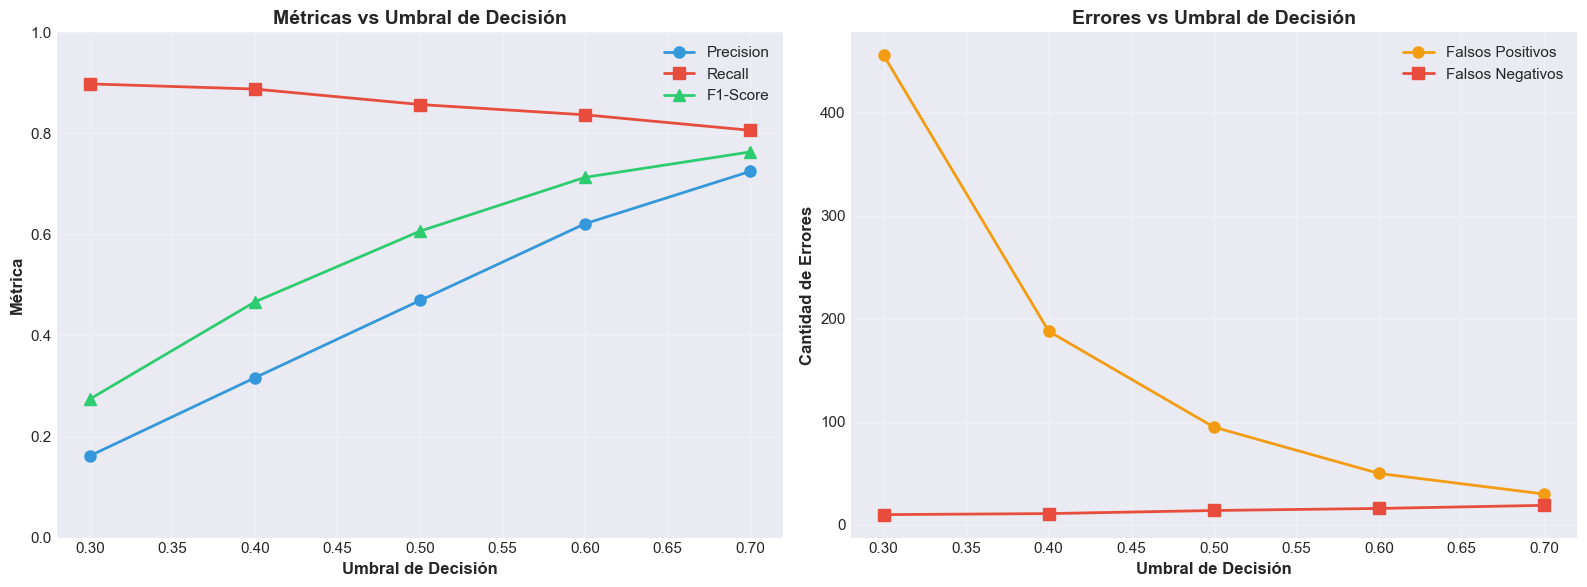

✅ Visualización de umbrales generada


In [49]:
# CELDA 13: Visualización de Trade-off Precision-Recall
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Precision vs Recall por umbral
axes[0].plot(results_df['Umbral'], results_df['Precision'], 
            'o-', color='#3498db', linewidth=2, markersize=8, label='Precision')
axes[0].plot(results_df['Umbral'], results_df['Recall'], 
            's-', color='#e74c3c', linewidth=2, markersize=8, label='Recall')
axes[0].plot(results_df['Umbral'], results_df['F1-Score'], 
            '^-', color='#2ecc71', linewidth=2, markersize=8, label='F1-Score')
axes[0].set_xlabel('Umbral de Decisión', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Métrica', fontsize=12, fontweight='bold')
axes[0].set_title('Métricas vs Umbral de Decisión', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

# Gráfico 2: FP vs FN por umbral
axes[1].plot(results_df['Umbral'], results_df['FP'], 
            'o-', color='#f39c12', linewidth=2, markersize=8, label='Falsos Positivos')
axes[1].plot(results_df['Umbral'], results_df['FN'], 
            's-', color='#e74c3c', linewidth=2, markersize=8, label='Falsos Negativos')
axes[1].set_xlabel('Umbral de Decisión', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cantidad de Errores', fontsize=12, fontweight='bold')
axes[1].set_title('Errores vs Umbral de Decisión', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualización de umbrales generada")

## 🔍 ANÁLISIS DE ERRORES

### ¿Por qué analizar errores?

Entender dónde falla el modelo nos ayuda a:
- Identificar patrones en fraudes no detectados
- Mejorar el modelo con feature engineering
- Definir reglas de negocio complementarias
- Comunicar limitaciones del sistema

---
## ❌ CELDA 14: Análisis de Falsos Negativos

❌ ANÁLISIS DE FALSOS NEGATIVOS

📊 Fraudes NO Detectados: 14
   • Porcentaje de fraudes perdidos: 14.29%

🔍 Probabilidades de los Fraudes No Detectados:
   • Media: 0.1939
   • Mediana: 0.1172
   • Mínima: 0.0156
   • Máxima: 0.4856

💡 INSIGHT:
   → El modelo está muy seguro de que NO son fraudes
   → Estos casos son difíciles de detectar


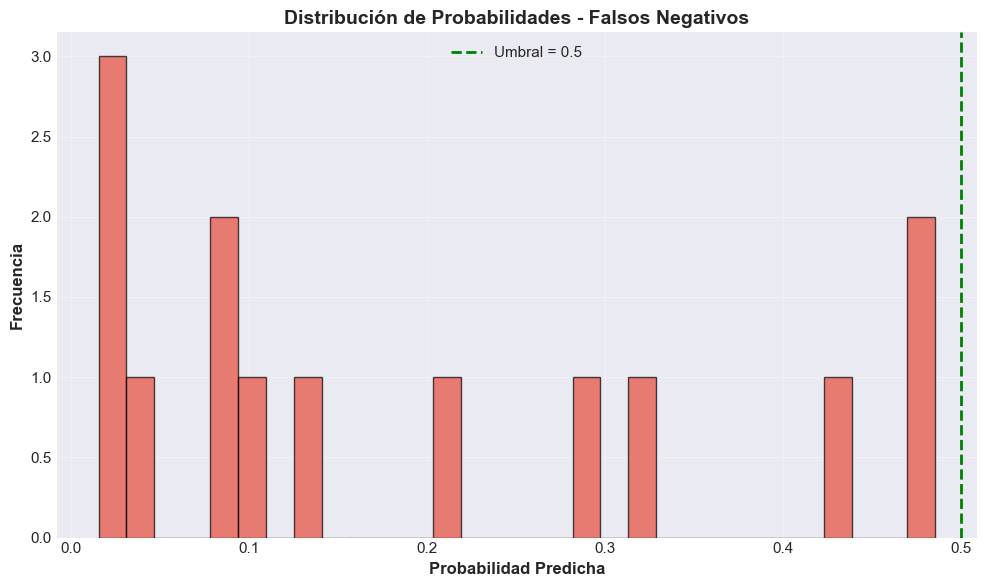

In [50]:
# CELDA 14: Análisis de Falsos Negativos (Fraudes No Detectados)
print("="*60)
print("❌ ANÁLISIS DE FALSOS NEGATIVOS")
print("="*60)

# Identificar falsos negativos
fn_mask = (y_test == 1) & (y_test_pred == 0)
fn_indices = y_test[fn_mask].index

print(f"\n📊 Fraudes NO Detectados: {len(fn_indices)}")
print(f"   • Porcentaje de fraudes perdidos: {len(fn_indices)/test_counts[1]*100:.2f}%")

# Analizar probabilidades de los FN
fn_probas = y_test_pred_proba[fn_mask]

print(f"\n🔍 Probabilidades de los Fraudes No Detectados:")
print(f"   • Media: {fn_probas.mean():.4f}")
print(f"   • Mediana: {np.median(fn_probas):.4f}")
print(f"   • Mínima: {fn_probas.min():.4f}")
print(f"   • Máxima: {fn_probas.max():.4f}")

print(f"\n💡 INSIGHT:")
if fn_probas.mean() < 0.3:
    print(f"   → El modelo está muy seguro de que NO son fraudes")
    print(f"   → Estos casos son difíciles de detectar")
elif fn_probas.mean() > 0.4:
    print(f"   → El modelo tiene dudas (probabilidades cercanas a 0.5)")
    print(f"   → Ajustar el umbral podría ayudar")

# Distribución de probabilidades de FN
plt.figure(figsize=(10, 6))
plt.hist(fn_probas, bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Umbral = 0.5')
plt.xlabel('Probabilidad Predicha', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Distribución de Probabilidades - Falsos Negativos', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'false_negatives_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---
## ⚠️ CELDA 15: Análisis de Falsos Positivos

⚠️ ANÁLISIS DE FALSOS POSITIVOS

📊 Falsas Alarmas: 95
   • Porcentaje de transacciones legítimas: 0.17%

🔍 Probabilidades de las Falsas Alarmas:
   • Media: 0.6640
   • Mediana: 0.6073
   • Mínima: 0.5006
   • Máxima: 0.9996

💡 INSIGHT:


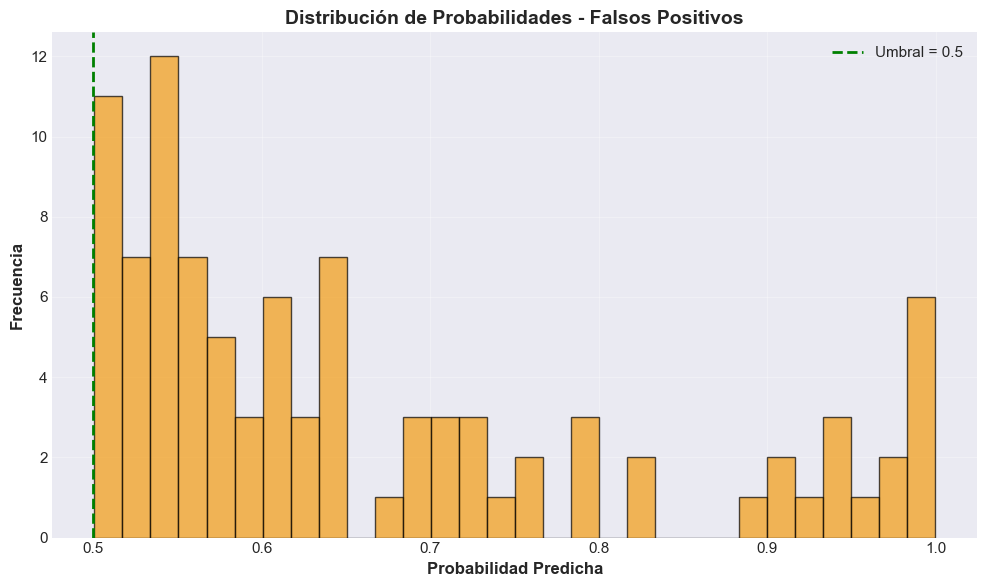

In [51]:
# CELDA 15: Análisis de Falsos Positivos (Falsas Alarmas)
print("="*60)
print("⚠️ ANÁLISIS DE FALSOS POSITIVOS")
print("="*60)

# Identificar falsos positivos
fp_mask = (y_test == 0) & (y_test_pred == 1)
fp_indices = y_test[fp_mask].index

print(f"\n📊 Falsas Alarmas: {len(fp_indices)}")
print(f"   • Porcentaje de transacciones legítimas: {len(fp_indices)/test_counts[0]*100:.2f}%")

# Analizar probabilidades de los FP
fp_probas = y_test_pred_proba[fp_mask]

print(f"\n🔍 Probabilidades de las Falsas Alarmas:")
print(f"   • Media: {fp_probas.mean():.4f}")
print(f"   • Mediana: {np.median(fp_probas):.4f}")
print(f"   • Mínima: {fp_probas.min():.4f}")
print(f"   • Máxima: {fp_probas.max():.4f}")

print(f"\n💡 INSIGHT:")
if fp_probas.mean() > 0.7:
    print(f"   → El modelo está MUY seguro de que son fraudes")
    print(f"   → Transacciones legítimas que 'parecen' fraudes")
elif fp_probas.mean() < 0.6:
    print(f"   → Probabilidades cercanas al umbral (0.5)")
    print(f"   → Casos en la frontera de decisión")

# Distribución de probabilidades de FP
plt.figure(figsize=(10, 6))
plt.hist(fp_probas, bins=30, color='#f39c12', edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Umbral = 0.5')
plt.xlabel('Probabilidad Predicha', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Distribución de Probabilidades - Falsos Positivos',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'false_positives_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 📊 CELDA 16: Comparación Validation vs Test

In [52]:
# CELDA 16: Comparación Validation vs Test
print("="*60)
print("📊 COMPARACIÓN: VALIDATION vs TEST")
print("="*60)

# Obtener métricas del mejor modelo en validation (del CSV)
best_model_name = type(best_model).__name__
if 'RandomForest' in best_model_name:
    val_metrics_row = metrics_df[metrics_df['model_name'] == 'Random Forest']
else:
    val_metrics_row = metrics_df[metrics_df['model_name'] == 'Logistic Regression']

comparison = pd.DataFrame([
    {
        'Conjunto': 'Validation',
        'Precision': f"{val_metrics_row['precision'].values[0]:.4f}",
        'Recall': f"{val_metrics_row['recall'].values[0]:.4f}",
        'F1-Score': f"{val_metrics_row['f1_score'].values[0]:.4f}",
        'ROC-AUC': f"{val_metrics_row['roc_auc'].values[0]:.4f}"
    },
    {
        'Conjunto': 'Test',
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}",
        'ROC-AUC': f"{roc_auc:.4f}"
    }
])

print("\n", comparison.to_string(index=False))

# Calcular diferencias
diff_precision = abs(precision - val_metrics_row['precision'].values[0])
diff_recall = abs(recall - val_metrics_row['recall'].values[0])
diff_f1 = abs(f1 - val_metrics_row['f1_score'].values[0])

print(f"\n📈 DIFERENCIAS (valor absoluto):")
print(f"   • Precision: {diff_precision:.4f}")
print(f"   • Recall: {diff_recall:.4f}")
print(f"   • F1-Score: {diff_f1:.4f}")

print(f"\n💡 EVALUACIÓN:")
if diff_f1 < 0.05:
    print(f"   ✅ Excelente generalización")
    print(f"   ✅ El modelo es consistente entre Val y Test")
    print(f"   ✅ Confiable para producción")
elif diff_f1 < 0.10:
    print(f"   ✅ Buena generalización")
    print(f"   ✅ Diferencias aceptables")
else:
    print(f"   ⚠️ Diferencias significativas")
    print(f"   ⚠️ Revisar posible overfitting")

📊 COMPARACIÓN: VALIDATION vs TEST

   Conjunto Precision Recall F1-Score ROC-AUC
Validation    0.4923 0.8101   0.6124  0.9688
      Test    0.4693 0.8571   0.6065  0.9801

📈 DIFERENCIAS (valor absoluto):
   • Precision: 0.0230
   • Recall: 0.0470
   • F1-Score: 0.0059

💡 EVALUACIÓN:
   ✅ Excelente generalización
   ✅ El modelo es consistente entre Val y Test
   ✅ Confiable para producción


---
## 📋 CELDA 17: Resumen Ejecutivo

In [53]:
# CELDA 17: Resumen Ejecutivo
print("="*60)
print("📋 RESUMEN EJECUTIVO - RESULTADOS FINALES")
print("="*60)

print(f"\n🤖 MODELO SELECCIONADO:")
print(f"   • Algoritmo: {type(best_model).__name__}")
print(f"   • Entrenado con: SMOTE (datos balanceados)")

print(f"\n📊 DESEMPEÑO EN TEST SET:")
print(f"   • Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   • Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • ROC-AUC: {roc_auc:.4f}")

print(f"\n🎯 RESULTADOS OPERACIONALES:")
print(f"   • Total de transacciones evaluadas: {len(y_test):,}")
print(f"   • Fraudes reales: {test_counts[1]:,}")
print(f"   • Fraudes detectados: {tp:,} ({tp/test_counts[1]*100:.1f}%)")
print(f"   • Fraudes perdidos: {fn:,} ({fn/test_counts[1]*100:.1f}%)")
print(f"   • Falsas alarmas: {fp:,} ({fp/test_counts[0]*100:.2f}% de legítimas)")

print(f"\n💰 IMPACTO ECONÓMICO ESTIMADO:")
print(f"   • Fraudes bloqueados: ${savings_from_blocked_frauds:,}")
print(f"   • Costo de fraudes perdidos: ${cost_missed_frauds:,}")
print(f"   • Costo de falsas alarmas: ${cost_false_alarms:,}")
print(f"   • BENEFICIO NETO: ${net_benefit:,}")

print(f"\n✅ CONCLUSIONES:")
if recall > 0.85:
    print(f"   ✅ Excelente tasa de detección de fraudes")
elif recall > 0.75:
    print(f"   ✅ Buena tasa de detección de fraudes")
else:
    print(f"   ⚠️ Tasa de detección mejorable")

if precision > 0.90:
    print(f"   ✅ Pocas falsas alarmas (alta precision)")
elif precision > 0.80:
    print(f"   ✅ Nivel aceptable de falsas alarmas")
else:
    print(f"   ⚠️ Considerar reducir falsas alarmas")

if net_benefit > 0:
    print(f"   ✅ El sistema genera valor económico positivo")
else:
    print(f"   ⚠️ Revisar balance de costos")

📋 RESUMEN EJECUTIVO - RESULTADOS FINALES

🤖 MODELO SELECCIONADO:
   • Algoritmo: RandomForestClassifier
   • Entrenado con: SMOTE (datos balanceados)

📊 DESEMPEÑO EN TEST SET:
   • Precision: 0.4693 (46.93%)
   • Recall: 0.8571 (85.71%)
   • F1-Score: 0.6065
   • ROC-AUC: 0.9801

🎯 RESULTADOS OPERACIONALES:
   • Total de transacciones evaluadas: 56,962
   • Fraudes reales: 98
   • Fraudes detectados: 84 (85.7%)
   • Fraudes perdidos: 14 (14.3%)
   • Falsas alarmas: 95 (0.17% de legítimas)

💰 IMPACTO ECONÓMICO ESTIMADO:
   • Fraudes bloqueados: $12,600
   • Costo de fraudes perdidos: $2,100
   • Costo de falsas alarmas: $2,375
   • BENEFICIO NETO: $8,125

✅ CONCLUSIONES:
   ✅ Excelente tasa de detección de fraudes
   ⚠️ Considerar reducir falsas alarmas
   ✅ El sistema genera valor económico positivo


## 🚀 RECOMENDACIONES PARA PRODUCCIÓN

### 1️⃣ Implementación del Modelo

**Arquitectura recomendada:**
```
Transacción → API → Preprocesamiento → Modelo → Decisión
                                          ↓
                                    Logging/Monitoring
```

**Componentes necesarios:**
- API REST para recibir transacciones
- Pipeline de preprocesamiento (scaler guardado)
- Modelo entrenado (.pkl)
- Sistema de logging
- Dashboard de monitoreo

### 2️⃣ Monitoreo Continuo

**Métricas a monitorear:**
- Tasa de predicciones de fraude (cambios drásticos = problema)
- Distribución de probabilidades
- Tiempo de respuesta
- Feedback de revisión manual

**Alertas:**
- Si tasa de fraudes predichos > X%
- Si tiempo de respuesta > Y segundos
- Si distribución de probabilidades cambia

### 3️⃣ Reentrenamiento

**Frecuencia sugerida:**
- Reentrenamiento completo: Cada 3-6 meses
- Validación de desempeño: Mensual
- Actualización si métricas caen > 5%

**Datos para reentrenar:**
- Transacciones nuevas etiquetadas
- Feedback de casos revisados manualmente
- Mantener balance temporal (no solo datos recientes)

### 4️⃣ Proceso de Revisión Manual

**Casos a revisar manualmente:**
- Todas las predicciones de fraude (TP + FP)
- Transacciones con probabilidad 0.4 - 0.6 (zona gris)
- Transacciones de alto monto

**Retroalimentación:**
- Etiquetar correctamente cada caso revisado
- Almacenar para futuro reentrenamiento
- Analizar patrones en errores

### 5️⃣ Consideraciones Legales y Éticas

**Transparencia:**
- Informar a clientes sobre uso de ML
- Proceso claro para disputar decisiones
- Explicabilidad de decisiones (feature importance)

**Privacidad:**
- Cumplir con regulaciones (GDPR, CCPA)
- Anonimización de datos
- Auditorías regulares

### 6️⃣ Mejoras Futuras

**Corto plazo (1-3 meses):**
- Implementar sistema de alertas
- Dashboard de monitoreo en tiempo real
- A/B testing con diferentes umbrales

**Medio plazo (3-6 meses):**
- Probar modelos más avanzados (XGBoost, LightGBM)
- Feature engineering adicional
- Ensemble con múltiples modelos

**Largo plazo (6-12 meses):**
- Deep Learning (redes neuronales)
- Detección de anomalías temporal
- Sistema de aprendizaje continuo

---
## 💾 CELDA 18: Guardar Reporte Final

In [54]:
# CELDA 18: Guardar Reporte Final
print("="*60)
print("💾 GUARDANDO REPORTE FINAL")
print("="*60)

# Crear reporte completo (convirtiendo tipos numpy a tipos nativos de Python)
final_report = {
    'Modelo': type(best_model).__name__,
    'Fecha_Evaluacion': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Total_Transacciones_Test': int(len(y_test)),
    'Fraudes_Reales': int(test_counts[1]),
    'Precision': float(precision),
    'Recall': float(recall),
    'F1_Score': float(f1),
    'ROC_AUC': float(roc_auc),
    'True_Positives': int(tp),
    'False_Positives': int(fp),
    'True_Negatives': int(tn),
    'False_Negatives': int(fn),
    'Fraudes_Detectados_Pct': float(tp/test_counts[1]*100),
    'Fraudes_Perdidos_Pct': float(fn/test_counts[1]*100),
    'Falsas_Alarmas_Pct': float(fp/test_counts[0]*100),
    'Beneficio_Neto_USD': int(net_benefit),
    'Ahorro_Fraudes_Bloqueados_USD': int(savings_from_blocked_frauds),
    'Costo_Fraudes_Perdidos_USD': int(cost_missed_frauds),
    'Costo_Falsas_Alarmas_USD': int(cost_false_alarms)
}

# Guardar como JSON
with open(MODELS_PATH / 'final_evaluation_report.json', 'w') as f:
    json.dump(final_report, f, indent=4)

print("\n✅ Reporte guardado: final_evaluation_report.json")

# También guardar como CSV para fácil lectura
report_df = pd.DataFrame([final_report])
report_df.to_csv(MODELS_PATH / 'final_evaluation_report.csv', index=False)
print("✅ Reporte guardado: final_evaluation_report.csv")

print(f"\n📁 Reportes guardados en: {MODELS_PATH}")

💾 GUARDANDO REPORTE FINAL

✅ Reporte guardado: final_evaluation_report.json
✅ Reporte guardado: final_evaluation_report.csv

📁 Reportes guardados en: c:\dev\repos-deep-learning\fraude-detection\models


## 🎉 NOTEBOOK COMPLETADO

### ✅ Lo que hemos logrado:

1. ✅ Evaluación completa en Test Set
2. ✅ Análisis de métricas detallado
3. ✅ Estudio de impacto económico
4. ✅ Visualizaciones avanzadas (ROC, PR curves)
5. ✅ Análisis de errores (FN y FP)
6. ✅ Comparación Val vs Test
7. ✅ Análisis de umbrales de decisión
